In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import os
import json
import time

device='cpu'

In [2]:
tokens = [
    '<START>', '<END>', '<PAD>', 'measure', 'note', 'pitch', 'step', 'alter',
    'octave', 'duration', 'type', 'rest', 'dot', 'staff', 'notations', 'slur',
    'ff', 'f', 'mf', 'mp', 'p', 'pp', 'backup', 'chord'] + list('ABCDEFG') \
+ ['-1'] + list('0123456789') + ['10', '11', '12', '13', '14', '15', '16'] + ['}'] \
+ ['whole', 'half', 'quarter', 'eighth', '16th']

word_to_ix = {word: i for i, word in enumerate(tokens)}
ix_to_word = {str(i): word for i, word in enumerate(tokens)}
len_lexicon = len(word_to_ix)

In [3]:
dataset_dir = 'storage/samples/'
lstm_hidden_size = 128
fc1_output_size = 128
seq_len = 64
batch_size = 64

In [4]:
def get_time_signature_layer(measure_length, height=224, width=224):
    x = np.zeros((height, width)).astype(np.uint8)
    if measure_length == 12:
        x[:int(height/2)] += 255
    if measure_length == 16:
        x[int(height/2):] += 255
    return x

def get_key_signature_layer(key_number, height=224, width=224):
    # key number is between -7 and 7 inclusive
    x = np.zeros((height, width)).astype(np.uint8)
    splits = np.array_split(x, 15)
    splits[key_number+7] += 255
    return x

In [5]:
class Dataset():
    def __init__(self, path, seq_len):
        self.seq_len = seq_len
        self.images = np.load(path + 'images.npy')
        self.measure_lengths = np.load(path + 'measure_lengths.npy')
        self.key_numbers = np.load(path + 'key_numbers.npy')
        with open(path + 'pc_data.json') as f:
            self.pc_data = json.load(f)
        self.sequences = []
        self.image_indices = []
        for i, pc in enumerate(self.pc_data):
            if len(pc) < seq_len+1:
                pc = pc + ['<PAD>']*(seq_len+1-len(pc))
            pc_as_ix = np.array([int(word_to_ix[word]) for word in pc])
            for j in range(len(pc)-seq_len):
                self.sequences.append(pc_as_ix[j:j+seq_len+1])
                self.image_indices.append(i)
        self.image_indices = np.array(self.image_indices)
        self.sequences = np.array(self.sequences)
            
    def get_batch(self, batch_size, val=False):
        validation_partition = int(len(self.sequences)*0.9)
        if not val:
            sequence_batch_indices = np.random.choice(len(self.sequences[:validation_partition]), size=batch_size)
        else:
            sequence_batch_indices = np.random.choice(len(self.sequences[validation_partition:]), size=batch_size)
        image_batch_indices = self.image_indices[sequence_batch_indices]
        raw_image_batch = self.images[image_batch_indices].reshape(-1, 1, 224, 224)
        measure_lengths_batch = self.measure_lengths[image_batch_indices]
        key_numbers_batch = self.key_numbers[image_batch_indices]
        measure_lengths_layers = []
        key_numbers_layers = []
        for i in range(batch_size):
            measure_length = measure_lengths_batch[i]
            key_number = key_numbers_batch[i]
            measure_lengths_layers.append(get_time_signature_layer(measure_length))
            key_numbers_layers.append(get_key_signature_layer(key_number))
        measure_lengths_layers = np.array(measure_lengths_layers).reshape(-1, 1, 224, 224)
        key_numbers_layers = np.array(key_numbers_layers).reshape(-1, 1, 224, 224)
        image_batch = np.concatenate([raw_image_batch, measure_lengths_layers, key_numbers_layers], axis=1)
        sequence_batch = self.sequences[sequence_batch_indices]
        image_batch = torch.Tensor(image_batch).type(torch.float).to(device)
        sequence_batch = torch.Tensor(sequence_batch).type(torch.long).to(device)
        return image_batch, sequence_batch, image_batch_indices

In [6]:
def get_datasets(n):
    all_datasets = os.listdir(dataset_dir)
    dataset_sample = []
    for _ in range(n):
        i = np.random.randint(len(all_datasets))
        filename = all_datasets[i]
        dataset = Dataset(dataset_dir + filename + '/', seq_len)
        dataset_sample.append(dataset)
    return dataset_sample

In [7]:
class ConvSubunit(nn.Module):
    def __init__(self, input_size, output_size, filter_size, stride, padding, dropout):
        super().__init__()
        self.conv = nn.Conv2d(input_size, output_size, filter_size, stride=stride, padding=padding)
        self.dp = nn.Dropout2d(p=dropout)
        self.bn = nn.BatchNorm2d(output_size)
        self.relu = nn.LeakyReLU()
        self.sequential = nn.Sequential(self.conv, self.dp, self.bn, self.relu)

    def forward(self, x):
        return self.sequential(x)
    
class LargeConvUnit(nn.Module):
    def __init__(self, input_size, output_size, filter_size, stride, padding, dropout):
        super().__init__()
        self.subunit1 = ConvSubunit(input_size, output_size, filter_size, 1, padding, dropout)
        self.subunit2 = ConvSubunit(output_size, output_size, filter_size, 1, padding, dropout)
        self.subunit3 = ConvSubunit(output_size, output_size, filter_size, 1, padding, dropout)
        self.subunit4 = ConvSubunit(output_size, output_size, filter_size, stride, padding, dropout)

    def forward(self, x):
        x = self.subunit1(x)
        cache = x
        x = self.subunit2(x)
        x = self.subunit3(x)
        x = x + cache
        x = self.subunit4(x)
        return x
    
class SmallConvUnit(nn.Module):
    def __init__(self, input_size, output_size, filter_size, stride, padding, dropout):
        super().__init__()
        self.subunit1 = ConvSubunit(input_size, output_size, filter_size, 1, padding, dropout)
        self.subunit2 = ConvSubunit(output_size, output_size, filter_size, stride, padding, dropout)

    def forward(self, x):
        x = self.subunit1(x)
        x = self.subunit2(x)
        return x

In [8]:
class SmallCNN(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.cnn = nn.Sequential(SmallConvUnit(3, 32, 3, 2, 1, 0.1), # (224, 224) --> (112, 112)
                                 SmallConvUnit(32, 64, 3, 2, 1, 0.1), # (112, 112) --> (56, 56)
                                 SmallConvUnit(64, 128, 3, 4, 1, 0.1), # (56, 56) --> (14, 14)
                                 SmallConvUnit(128, 256, 3, 7, 1, 0.1)) # (14, 14) --> (2, 2)
        self.fc = nn.Linear(1024, output_size)
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x
        
class LargeCNN(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.cnn = nn.Sequential(LargeConvUnit(3, 32, 3, 2, 1, 0.1), # (224, 224) --> (112, 112)
                                 LargeConvUnit(32, 64, 3, 2, 1, 0.1), # (112, 112) --> (56, 56)
                                 LargeConvUnit(64, 128, 3, 4, 1, 0.1), # (56, 56) --> (14, 14)
                                 LargeConvUnit(128, 256, 3, 7, 1, 0.1)) # (14, 14) --> (2, 2)
        self.fc = nn.Linear(1024, output_size)
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x
        
class SqueezeCNN(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.cnn = torchvision.models.squeezenet1_0(pretrained=True)
        self.cnn.classifier[1] = nn.Conv2d(512, output_size, kernel_size=(1,1), stride=(1,1))
        
    def forward(self, x):
        x = self.cnn(x)
        return x

In [9]:
class Net(nn.Module):
    def __init__(self, save_dir, cnn, len_lexicon, lstm_hidden_size, fc1_output_size, device, num_directions=1):
        super().__init__()
        self.save_dir = save_dir
        self.len_lexicon = len_lexicon
        self.lstm_hidden_size = lstm_hidden_size
        self.fc1_output_size = fc1_output_size
        self.num_directions = num_directions
        self.bidirectional = (num_directions==2)
        self.cnn = cnn
        self.embed = nn.Embedding(num_embeddings=self.len_lexicon, embedding_dim=5)
        self.lstm1 = nn.LSTM(input_size=5,
                             hidden_size=self.lstm_hidden_size,
                             num_layers=2,
                             batch_first=True,
                             dropout=0.3,
                             bidirectional=self.bidirectional)
        self.lstm2 = nn.LSTM(input_size=self.fc1_output_size+self.num_directions*self.lstm_hidden_size,
                             hidden_size=self.lstm_hidden_size,
                             num_layers=2,
                             batch_first=True,
                             dropout=0.3,
                             bidirectional=self.bidirectional)
        self.fc2 = nn.Linear(self.num_directions*self.lstm_hidden_size, self.len_lexicon)
        
    def forward(self, image_input, sequence_input, internal1=None, internal2=None):
        bs = image_input.shape[0]
        sl = sequence_input.shape[1]
        if internal1:
            h1, c1 = internal1
        else:
            h1 = torch.zeros(2*self.num_directions, bs, self.lstm_hidden_size).to(device)
            c1 = torch.zeros(2*self.num_directions, bs, self.lstm_hidden_size).to(device)
        if internal2:
            h2, c2 = internal2
        else:
            h2 = torch.zeros(2*self.num_directions, bs, self.lstm_hidden_size).to(device)
            c2 = torch.zeros(2*self.num_directions, bs, self.lstm_hidden_size).to(device)
        image_output = self.cnn(image_input)
        image_output = image_output.repeat(1, sl).view(bs, sl, self.fc1_output_size)
        sequence_output, (h1, c1) = self.lstm1(self.embed(sequence_input), (h1, c1))
        concatenated = torch.cat([image_output, sequence_output], 2)
        lstm2_out, (h2, c2) = self.lstm2(concatenated, (h2, c2))
        out = self.fc2(lstm2_out)
        return out, (h1, c1), (h2, c2)
    
    def fit(self, iterations, batch_size, optimizer, loss_fn, print_every=100, save_every=5000, train_time=0, past_iterations=0):
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        time_checkpoint = time.time()
        for i in range(iterations):
            self.train()
            if i % 500 == 0:
                dataset = get_datasets(1)[0]
            arr, seq, _ = dataset.get_batch(batch_size)
            seq1 = seq[:, :-1]
            seq2 = seq[:, 1:]
            out, _, _ = self.forward(arr, seq1)
            out = out.view(-1, self.len_lexicon)
            targets = seq2.reshape(-1)
            loss = loss_fn(out, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
#                 out_val = out_val.cpu().detach().numpy().reshape(64, len_lexicon)
#                 out_val = out_val.argmax(axis=1)
#                 out_val = [ix_to_word[str(x)] for x in out_val]
#                 targets_val = [ix_to_word[str(x)] for x in targets_val.cpu().detach().numpy()]
#                 print('train loss: ', loss)
#                 print('val loss: ', val_loss)
#                 print(out_val)
#                 print(targets_val)
#                 print('----------------------------------------------')
            
            
#             out_simplified = out.cpu().detach().numpy().reshape(64, len_lexicon)
#             out_simplified = out_simplified.argmax(axis=1)
#             out_simplified = [ix_to_word[str(x)] for x in out_simplified]
#             targets_simplified = [ix_to_word[str(x)] for x in targets.cpu().detach().numpy()]
#             print(out_simplified)
#             print(targets_simplified)
#             print('--------------------------')
            
            train_time += time.time() - time_checkpoint
            time_checkpoint = time.time()
            if i % print_every == 0:
                with torch.no_grad():
                    arr_val, seq_val, _ = dataset.get_batch(batch_size, val=True)
                    seq1_val = seq_val[:, :-1]
                    seq2_val = seq_val[:, 1:]
                    out_val, _, _ = self.forward(arr_val, seq1_val)
                    out_val = out_val.view(-1, self.len_lexicon)
                    targets_val = seq2_val.reshape(-1)
                    val_loss = loss_fn(out_val, targets_val)
                arr, _, image_batch_indices = dataset.get_batch(1, val=True)
                pc = dataset.pc_data[image_batch_indices[0]]
                pc = ' '.join(pc)
                pred_seq = self.predict(arr)
                pred_seq = ' '.join(pred_seq)
                pred_seq2 = self.predict_stochastic(arr)
                pred_seq2 = ' '.join(pred_seq2)
                arr_val, _, image_batch_indices = dataset.get_batch(1, val=False)
                true_val = dataset.pc_data[image_batch_indices[0]]
                true_val = ' '.join(true_val)
                pred_val = self.predict(arr_val)
                pred_val = ' '.join(pred_val)
                with open(f'{self.save_dir}log.txt', 'a+') as f:
                    info_string = f"""
                    ----
                    iteration: {i}
                    time elapsed: {train_time}
                    train loss: {loss}
                    val loss: {val_loss}
                    ----
                    pred1: {pred_seq}
                    ----
                    pred2: {pred_seq2}
                    ----
                    true:  {pc}
                    ----
                    pred_val: {pred_val}
                    ----
                    true_val: {true_val}
                    ----



                    """.replace('    ', '')
                    print(info_string)
                    f.write(info_string)
            if i % save_every == 0 and i != 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.99
                torch.save(self.state_dict(), f'{self.save_dir}checkpoint_iteration_{past_iterations+i}.pt')
                with open(f'{self.save_dir}training_info.json', 'w+') as f:
                    json.dump({'train_time': train_time, 'past_iterations': past_iterations+i}, f)
                    
    def resume_fit(self, iterations, optimizer, loss_fn, print_every=100, save_every=5000):
        with open(f'{self.save_dir}training_info.json', 'w+') as f:
            training_info = json.load(f)
        train_time = training_info['train_time']
        past_iterations = training_info['past_iterations']
        checkpoint = torch.load(f'{self.save_dir}checkpoint_iteration_{past_iterations}.pt')
        self.load_state_dict(checkpoint)
        self.fit(iterations, optimizer, loss_fn, print_every=print_every, save_every=save_every, train_time=train_time, past_iterations=past_iterations)
                
             
    def predict(self, arr):
        self.eval()    
        with torch.no_grad():
            arr = arr.view(1,3, 224, 224)
            output_sequence = ['<START>']
            h1 = torch.zeros(2*self.num_directions, 1, self.lstm_hidden_size).to(device)
            c1 = torch.zeros(2*self.num_directions, 1, self.lstm_hidden_size).to(device)
            h2 = torch.zeros(2*self.num_directions, 1, self.lstm_hidden_size).to(device)
            c2 = torch.zeros(2*self.num_directions, 1, self.lstm_hidden_size).to(device)
            while output_sequence[-1] != '<END>' and len(output_sequence)<400:
                sequence_input = torch.Tensor([word_to_ix[output_sequence[-1]]]).type(torch.long).view(1, 1).to(device)
                out, (h1, c1), (h2, c2) = self.forward(arr, sequence_input, (h1, c1), (h2, c2))
                _, sequence_input = out[0, 0, :].max(0)
                output_sequence.append(ix_to_word[str(sequence_input.item())])
        self.train()
        return output_sequence
    
    def predict_stochastic(self, arr):
        self.eval()    
        with torch.no_grad():
            arr = arr.view(1,3, 224, 224)
            output_sequence = ['<START>']
            h1 = torch.zeros(2*self.num_directions, 1, self.lstm_hidden_size).to(device)
            c1 = torch.zeros(2*self.num_directions, 1, self.lstm_hidden_size).to(device)
            h2 = torch.zeros(2*self.num_directions, 1, self.lstm_hidden_size).to(device)
            c2 = torch.zeros(2*self.num_directions, 1, self.lstm_hidden_size).to(device)
            while output_sequence[-1] != '<END>' and len(output_sequence)<400:
                sequence_input = torch.Tensor([word_to_ix[output_sequence[-1]]]).type(torch.long).view(1, 1).to(device)
                out, (h1, c1), (h2, c2) = self.forward(arr, sequence_input, (h1, c1), (h2, c2))
                log_probs = out[0, 0, :].cpu().numpy()
                probs = np.exp(log_probs) / np.exp(log_probs).sum()
                predicted_ix = np.random.choice(len_lexicon, p=probs)
                output_sequence.append(ix_to_word[str(predicted_ix)])
        self.train()
        return output_sequence

In [10]:
large_cnn = LargeCNN(fc1_output_size).to(device)
large_loss_fn = nn.CrossEntropyLoss()
large_net = Net(f'storage/large_model_lr3e-4/', large_cnn, len_lexicon, lstm_hidden_size, fc1_output_size, device).to(device)
large_optimizer = torch.optim.Adam(large_net.parameters(), lr=3e-4)

In [32]:
# large_net.fit(500000, batch_size, large_optimizer, large_loss_fn)

In [33]:
# for lr in np.linspace(1e-5, 1e-4, 5):
#     small_cnn = SmallCNN(fc1_output_size).to(device)
#     small_loss_fn = nn.CrossEntropyLoss()
#     small_net = Net(f'storage/small_model_learning_rate_testing/{lr}/', small_cnn, len_lexicon, lstm_hidden_size, fc1_output_size, device).to(device)
#     small_optimizer = torch.optim.Adam(small_net.parameters(), lr=lr)
#     small_net.fit(1000, batch_size, small_optimizer, small_loss_fn)

In [11]:
large_net.load_state_dict(torch.load('large_net_checkpoint_iteration_345000.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
from skimage import io, transform
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [13]:
images = np.load('../quarters_no_chords_rests_c/images.npy')
measure_lengths = np.load('../quarters_no_chords_rests_c/measure_lengths.npy')

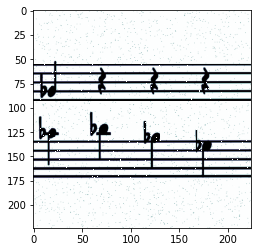

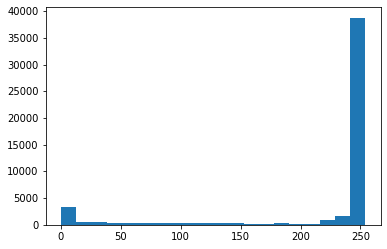

In [14]:
image = images[-10]
plt.imshow(image, cmap='bone')
plt.show()

plt.hist(image[image != image.max()].reshape(-1), bins=20)
plt.show()

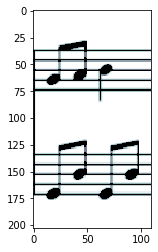

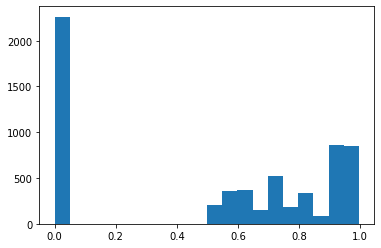

In [15]:
image = io.imread('test_measures/oot.png')
image = rgb2gray(image)

image[image < 0.5] = 0
plt.imshow(image, cmap='bone')
plt.show()

# image[image > 0.5] = np.power(image[image > 0.5], 1/100)
# plt.imshow(image, cmap='bone')
# plt.show()

plt.hist(image[image != image.max()].reshape(-1), bins=20)
plt.show()

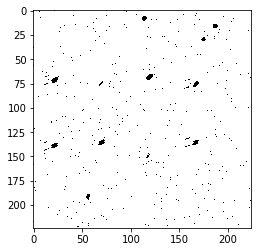

['<START>', 'measure', 'note', 'pitch', 'E', '0', '4', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'C', '0', '5', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'F', '0', '4', '}', 'duration', '4', '}', 'type', 'quarter', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'C', '0', '4', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'F', '0', '4', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'C', '-1', '4', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'E', '1', '4', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'note', 'rest', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'C', '0', '4', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'F', '-1', '4', '}', 'duration', '1'

In [16]:
image = images[-20]
image[image > 0.1] = 1
image[image < 0.1] = 0
plt.imshow(image, cmap='bone')
plt.show()
image = image.reshape(1, 1, 224, 224)
measure_length = measure_lengths[-20]
key_number = 0
time_sig_layer = get_time_signature_layer(measure_length).reshape(1, 1, 224, 224)
key_sig_layer = get_key_signature_layer(key_number).reshape(1, 1, 224, 224)
arr = np.concatenate([image, time_sig_layer, key_sig_layer], axis=1)
arr = torch.Tensor(arr).type(torch.float).to(device)
print(large_net.predict(arr))

In [ ]:
print(image)

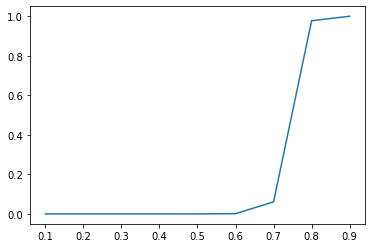

In [42]:
from scipy.special import beta

def g(x):
    return np.tan(np.pi*x - np.pi/2)
def f(x, a):
    return 1/(1+np.exp(a*(-(g(x)-1))))

x = np.arange(0.1, 1, 0.1)
plt.plot(x, f(x, 10))

In [18]:
def predict_from_image(model, path):
    image = io.imread(path)
    image = rgb2gray(image)
    measure_length = 12
    key_number = 0
    image = transform.resize(image, (224, 224))
    plt.imshow(image, cmap='bone')
    plt.show()
    image = image.reshape(1, 1, 224, 224)
    if image.max() < 2:
        image = image.reshape(1, 1, 224, 224)*255
    else:
        image = image.reshape(1, 1, 224, 224)
    image = image.astype(np.uint8)
    image = np.clip(image, 0, 255)
    time_sig_layer = get_time_signature_layer(measure_length).reshape(1, 1, 224, 224)
    key_sig_layer = get_key_signature_layer(key_number).reshape(1, 1, 224, 224)
    arr = np.concatenate([image, time_sig_layer, key_sig_layer], axis=1)
    arr = torch.Tensor(arr).type(torch.float).to(device)
    print(model.predict(arr))

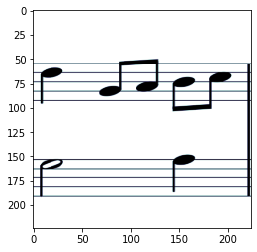

['<START>', 'measure', 'note', 'pitch', 'E', '0', '5', '}', 'duration', '4', '}', 'type', 'quarter', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'G', '0', '4', '}', 'duration', '2', '}', 'type', 'eighth', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'A', '0', '4', '}', 'duration', '2', '}', 'type', 'eighth', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'B', '0', '4', '}', 'duration', '2', '}', 'type', 'eighth', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'C', '0', '5', '}', 'duration', '2', '}', 'type', 'eighth', '}', 'staff', '1', '}', '}', 'backup', 'duration', '12', '}', '}', 'note', 'pitch', 'G', '0', '3', '}', 'duration', '8', '}', 'type', 'half', '}', 'staff', '2', '}', '}', 'note', 'pitch', 'A', '0', '3', '}', 'duration', '4', '}', 'type', 'quarter', '}', 'staff', '2', '}', '}', '}', '<END>']


In [19]:
predict_from_image(large_net, 'test_measures/minuet_measure.png')

In [21]:
image = io.imread('test_measures/oot.png')
image = rgb2gray(image)
print(image.max())

1.0


In [22]:
print(image)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [78]:
from pc_to_xml import pc_to_xml

def xml_from_image(model, path):
    image = io.imread(path)
    image = rgb2gray(image)
    measure_length = 16
    key_number = 0
    image = transform.resize(image, (224, 224))
    plt.imshow(image, cmap='bone')
    image = image.reshape(1, 1, 224, 224)*255
    time_sig_layer = get_time_signature_layer(measure_length).reshape(1, 1, 224, 224)
    key_sig_layer = get_key_signature_layer(key_number).reshape(1, 1, 224, 224)
    arr = np.concatenate([image, time_sig_layer, key_sig_layer], axis=1)
    arr = torch.Tensor(arr).type(torch.float).to(device)
    xml = pc_to_xml(model.predict(arr)[1:-1], 16, 0)
    return xml

TypeError: 'NoneType' object is not iterable

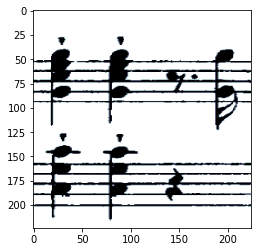

In [88]:
with open('sample_measure.musicxml', 'w+') as f:
    f.write(str(xml_from_image(large_net, 'test_measures/schubert1.png')))

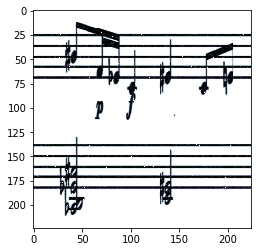

['<START>', 'measure', 'note', 'pitch', 'A', '1', '4', '}', 'duration', '2', '}', 'type', 'eighth', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'G', '0', '4', '}', 'duration', '2', '}', 'type', 'eighth', '}', 'staff', '1', '}', '}', 'f', '}', 'note', 'pitch', 'D', '-1', '4', '}', 'duration', '2', '}', 'type', 'eighth', '}', 'staff', '1', '}', '}', 'f', '}', 'note', 'pitch', 'D', '1', '4', '}', 'duration', '4', '}', 'type', 'quarter', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'D', '0', '4', '}', 'duration', '4', '}', 'type', 'quarter', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'C', '0', '4', '}', 'duration', '3', '}', 'type', 'eighth', '}', 'dot', '}', 'staff', '1', '}', '}', 'note', 'pitch', 'C', '0', '4', '}', 'duration', '1', '}', 'type', '16th', '}', 'staff', '1', '}', '}', 'backup', 'duration', '16', '}', '}', 'note', 'pitch', 'C', '-1', '2', '}', 'duration', '8', '}', 'type', 'half', '}', 'staff', '2', '}', '}', 'note', 'chord', '}', 'pitch', 'D', '-1', '2', '}', 'durati

In [22]:
from nltk.translate.bleu_score import sentence_bleu

bleu_scores = []
for filename in os.listdir('../music-score-converter/samples/'):
    if filename[-3:] != '.py':
        images = np.load(f'../music-score-converter/samples/{filename}/images.npy')
        measure_lengths = np.load(f'../music-score-converter/samples/{filename}/measure_lengths.npy')
        with open(f'../music-score-converter/samples/{filename}/pc_data.json') as f:
            pc_data = json.load(f)
        image = images[-1]
        plt.imshow(image, cmap='bone')
        plt.show()
        image = image.reshape(1, 1, 224, 224)
        measure_length = measure_lengths[-1]
        key_number = 0
        time_sig_layer = get_time_signature_layer(measure_length).reshape(1, 1, 224, 224)
        key_sig_layer = get_key_signature_layer(key_number).reshape(1, 1, 224, 224)
        arr = np.concatenate([image, time_sig_layer, key_sig_layer], axis=1)
        arr = torch.Tensor(arr).type(torch.float).to(device)
        pred = large_net.predict(arr)
        print(pred)
        print(pc_data[-1])
        bleu_score = sentence_bleu([pred], pc_data[-1])
        print(bleu_score)
        bleu_scores.append(bleu_score)
        print('-------------------------')
        print('-------------------------')    
        print('-------------------------')    
        print('-------------------------')
    
print('mean bleu_score: ', np.mean(bleu_scores))